# The bias variance tradeoff

### Introduction

We have now been exposed to the three different sources of error that can arise in our model.  Here are the three sources:

* **bias** when our model does not include one or more features that contributes to variations in outcomes of our data.  
* **variance** when we include too many features in our model that make our models too flexible, such that it picks up on randomness in the data.  
* **irreducible error** which occurs due to a degree of randomness in our target variable. 

As we know, we cannot eliminate irreducible error.  But we can develop techniques for not including too few parameters and thus contributing bias, or too many parameters and thus introducing variance, into our model.

### Setting up our data

So far we have seen a model that suffers from bias, one from variance, and another that has the correct number of variables.  In this lesson, we'll take a look at each of these types of models togther and see how they compare.

Now to create these three models, we'll just use the same process of inititializing our model, fitting the data and looking at some scores.  The only difference between the models will be the features that we pass into the models.  Lucky for us, we already have these features loaded in a separate file.  

So let's load up the data, and then fit three different models with the following features:

1. temperatures,
2. temperatures and weekends, and
3. temperatures, weekends and ages

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/jigsawlabs-student/train-test-split/master/7-bias-variance-tradeoff/customers_with_ages.csv"
df = pd.read_csv(url, index_col = 0)

In [30]:
df_sorted = df.sort_values('temp')

In [43]:
from sklearn.linear_model import LinearRegression
y = df_sorted['customers']
models = []
for i in range(1, 4):
    X = df_sorted.iloc[:, :i]
    model = LinearRegression()
    model.fit(X, y)
    models.append(model)
models

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)]

In [32]:
intercepts = [model.intercept_ for model in models]
# [35.62031572335471, 9.854773197812762, 12.155548281106803]
coefs = [model.coef_ for model in models]
coefs

[array([2.87988515]),
 array([ 3.07299452, 38.61313304]),
 array([ 3.05231752, 39.15999752, -0.43176901])]

Ok, let's take a look at these models.

In [33]:
y_preds = []
for i in range(0, 3):
    y_pred = models[i].predict(df_sorted.iloc[:, :i + 1])
    y_preds.append(y_pred)

In [40]:
import plotly.graph_objects as go
models_traces = [go.Scatter(x = df_sorted['temp'], y = preds) for preds in y_preds]

In [41]:
data_trace = go.Scatter(x = df_sorted['temp'], y = df_sorted['customers'], mode = 'markers')

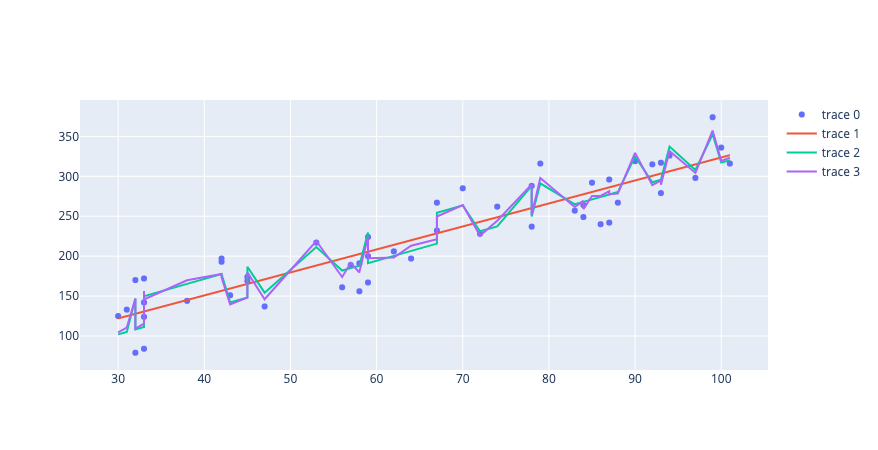

In [42]:
go.Figure(data = [data_trace,*models_traces])

> Now it may look like there are only two models, but there are three, and they are different.  Hover your cursor over the plot and you can see the slight differences between our two feature and three feature models.

### Choosing a model

Now let's move into our process for choosing a model.  The first thing we may want to do is look at the scores for each of these models.

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt
feature_datasets = [df_sorted.iloc[:, :i] for i in range(1, 4)]


In [66]:
rmses = [sqrt(mean_squared_error(df_sorted['customers'], model.predict(dataset)))
         for model, dataset in zip(models, feature_datasets)]

In [67]:
rmses

[27.945349336535738, 21.565735597602885, 20.981542668372782]

Now we can see that each of has progressively better scores.

However, as we mentioned previously the new feature in our last model is the influence of our random list of cashier ages to customers.  This model is just using this random list to find an association between cashier age and customers that doesn't exist.  It's simply coincidence that there exists this association.  This is another case of us overfitting to the randomness in the data

### But how do we know?

Now the way to detect this overfitting is to use a holdout set.  Here's how we do this:

1. We separate our model into two groups.  
    * A random selection of 80 percent of the data, and then the remaining 20 percent of the data.  
2. We'll then train our data on just the 80 percent of the data
3. Finally, we see how well our model performs on the remaining 20 percent of the data that was not a part of the training process.  

Here's why this should work:

1. **If the association is real**, then the detected association should continue to be informative even on data the our model did not see.  
2. **If the association is not real** then this means that our model just found a random association that is not likely to be replicated on the holdout set.

### Time to try it

Ok, let's try it.  We'll create holdout sets by splitting our data into a group of holdout training data and holdout data.  So let's first train the three models on the training datasets.  We'll do this by selecting roughly two thirds of the data to train our model on and use the rest of the data for the holdout set.

In [87]:
trained_models = []
training_predictions = []
training_customers = df_sorted['customers'][0:40]
for feature_data in feature_datasets:
    model = LinearRegression()
    model.fit(feature_data[0:40], training_customers)
    trained_models.append(model)

And we can see how well our feature data fits to the data that we trained on.

In [88]:
training_predictions = []
for feature_data, trained_model in zip(feature_datasets, trained_models):
    training_predictions.append(trained_model.predict(feature_data[0:40]))

In [89]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt
training_rmses = [sqrt(mean_squared_error(training_prediction, training_customers)) 
                  for training_prediction in training_predictions]
training_rmses

[28.57642807023796, 22.728379845476898, 21.93464426819013]

So as we can see on our training data, our training errors decrease with every new parameter that we add.  Now let's see how each of our trained models performs with our holdout data.

In [90]:
holdout_predictions = []

for feature_data, trained_model in zip(feature_datasets, trained_models):
    holdout_predictions.append(trained_model.predict(feature_data[40:]))

In [92]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt
holdout_customers = df_sorted['customers'][40:]

holdout_rmses = [sqrt(mean_squared_error(holdout_prediction, holdout_customers)) 
                 for holdout_prediction in holdout_predictions]
holdout_rmses

[27.53605998174632, 16.700571401608894, 17.578149516878966]

So here we can see that our models do not improve with each added parameter.  Rather we see that our bias variance tradeoff reflected in these scores.  The first score is for our one parameter model, which is biased.  Then the second score has our two parameter model, which has the proper features of temps and weekend.  And our final model has three an irrelevant parameter of `random_ages` and thus suffers from variance. 

| model                  |train rmse | holdout rmse |  
| ---------------------- |:---------:| :------------:|
| temps, ages, weekend   | 28.47     |  27.53        |
| temps, weekend         | 22.72     |  16.70       |
| temps                  | 21.93     |  17.57         | 

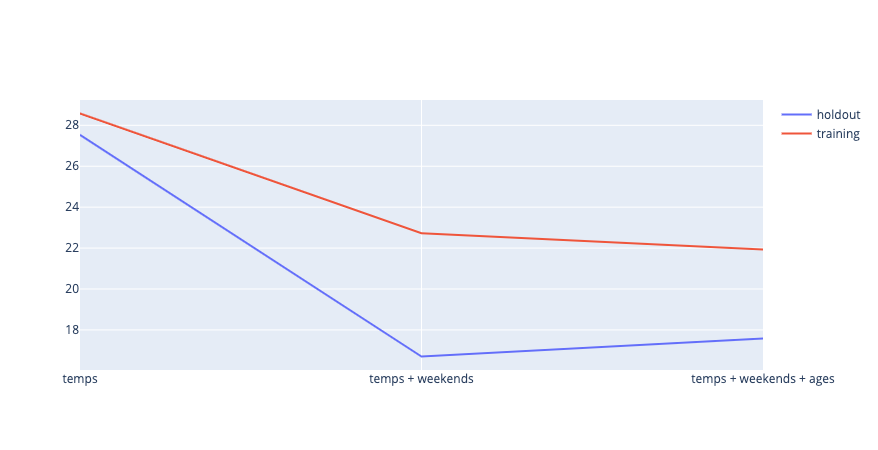

In [93]:
import plotly.graph_objects as go

model_parameters = ['temps', 'temps + weekends', 'temps + weekends + ages']
training_trace = go.Scatter(x = model_parameters, y = training_rmses, 
                              mode = 'lines', 
                              name = 'training')
holdout_trace = go.Scatter(x = model_parameters, 
                             y = holdout_rmses, 
                             mode = 'lines', name = 'holdout')
go.Figure(data = [holdout_trace, training_trace])

The above is a typical graph in machine learning.  As we add more features, the training scores tend to continue to improve.  However, at a certain point adding too many features has our model suffer from variance, so our holdout scores do not continue to improve.  The peak of our holdout scores is showing our best version of the model, which is the second model.

So this technique can help us toanswer when our models suffer from bias and when they suffer from variance.  
* In the first model, where we are only training on temperatures, our model suffers from bias, as it does not capture the variation that comes from being a weekend.  
* In the third model, we suffer from overfitting, which increases our error due to variance.  By adding an irrelevant feature such as age of the cashier to train on, our model's error decreases on the training set.  But this is just the model adjusting to randomness, which we see because our model does not generalize to future data. 
* The second model, where the error of our holdout set reaches the lowest point, is the model we choose.

### Summary

In this lesson, we learned about the bias variance tradeoff.  There are two main charts that we saw.  The first is that as we add more features, our models become more flexible, and are able to capture the variation in the data.

But the second shows some of the variation in the data is likely randomness.  We see that as we add more features, the error on our training dataset continues to reduce.  However, at a certain point these improved scores on our training set are due to the models fitting to randomness in the data that is unlikely to generalize.  We see this, when by adding more parameters the performance on the holdout set gets worse.  This displays overfitting to the training set.  To combat against overfitting, we choose the model that performs best on the holdout set.